# ---------------------------
# Imports
# ---------------------------

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel, friedmanchisquare
import matplotlib.pyplot as plt
import random


# SSL checkpoints path (Kaggle working folder)

In [5]:
SSL_MODELS = {
    "SimCLR": "/kaggle/input/ssl1-3/ssl_checkpoints/SimCLR_encoder.pth",
    "MAE":   "/kaggle/input/ssl1-3/ssl_checkpoints/MAE_encoder.pth",
    "Barlow":   "/kaggle/input/ssl1-3/ssl_checkpoints/barlow_encoder.pth",
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# Dataset + label efficiency splits

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(
    root="/kaggle/working/data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root="/kaggle/working/data",
    train=False,
    download=True,
    transform=transform
)

LABEL_RATIOS = [1, 5, 10, 100]  # Task 2 grid
SEEDS = [0, 1, 2]

100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s] 


# Linear probe

In [9]:
class LinearProbe(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(2048, 10)

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x).squeeze()
        return self.fc(x)


def train_linear_probe(encoder, train_loader, test_loader, epochs=20):
    model = LinearProbe(encoder).to(DEVICE)
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for _ in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            loss = criterion(model(x), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(DEVICE)
            preds.extend(model(x).argmax(1).cpu().numpy())
            labels.extend(y.numpy())

    return accuracy_score(labels, preds)


#  Run experiments

In [10]:
def load_ssl_encoder(ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)

    # Case 1: full model saved
    if isinstance(ckpt, nn.Module):
        encoder = ckpt

    # Case 2: only state_dict saved
    elif isinstance(ckpt, dict):
        encoder = nn.Sequential()
        encoder.load_state_dict(ckpt, strict=False)

    else:
        raise ValueError("Unsupported checkpoint format")

    encoder = encoder.to(device)
    encoder.eval()
    return encoder


# Feature dimension auto detect

In [11]:
def get_feature_dim(encoder, device):
    with torch.no_grad():
        dummy = torch.randn(1,3,32,32).to(device)
        feat = encoder(dummy)
        feat = torch.flatten(feat, 1)
    return feat.shape[1]


# Linear Probe (generic)

In [12]:
class LinearProbe(nn.Module):
    def __init__(self, encoder, feat_dim, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
            x = torch.flatten(x, 1)
        return self.fc(x)


# Train + Evaluate Linear Probe

In [13]:
def train_linear_probe(encoder, feat_dim, train_loader, test_loader, device, epochs=15):
    model = LinearProbe(encoder, feat_dim).to(device)
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for _ in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            loss = criterion(model(x), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            preds.extend(model(x).argmax(1).cpu().numpy())
            labels.extend(y.numpy())

    return accuracy_score(labels, preds)

# MAIN LOOP (Baseline + Ablation)

In [14]:
results = []

for model_name, ckpt_path in SSL_MODELS.items():
    print("Running:", model_name)

    encoder = load_ssl_encoder(ckpt_path, DEVICE)
    feat_dim = get_feature_dim(encoder, DEVICE)

    for ratio in LABEL_RATIOS:
        for seed in SEEDS:
            random.seed(seed)
            idx = np.random.choice(
                len(train_dataset),
                int(len(train_dataset)*ratio/100),
                replace=False
            )
            subset = Subset(train_dataset, idx)

            test_loader = DataLoader(test_dataset, batch_size=256)

            # Baseline
            train_loader = DataLoader(subset, batch_size=256, shuffle=True)
            acc = train_linear_probe(
                encoder, feat_dim, train_loader, test_loader, DEVICE
            )
            results.append([model_name,"baseline",ratio,seed,acc])

            # Ablation
            train_loader = DataLoader(subset, batch_size=64, shuffle=True)
            acc = train_linear_probe(
                encoder, feat_dim, train_loader, test_loader, DEVICE
            )
            results.append([model_name,"batch64",ratio,seed,acc])


Running: SimCLR
Running: MAE
Running: Barlow


# Results table + Statistics

In [15]:
df = pd.DataFrame(
    results,
    columns=["Model","Setting","LabelRatio","Seed","Accuracy"]
)
df


,Model,Setting,LabelRatio,Seed,Accuracy
0,SimCLR,baseline,1,0,0.2990
1,SimCLR,batch64,1,0,0.2819
2,SimCLR,baseline,1,1,0.2883
3,SimCLR,batch64,1,1,0.2791
4,SimCLR,baseline,1,2,0.3010
...,...,...,...,...,...
67,Barlow,batch64,100,0,0.3667
68,Barlow,baseline,100,1,0.3988
69,Barlow,batch64,100,1,0.3841
70,Barlow,baseline,100,2,0.3957


# Paired t-test

In [16]:
for model in df.Model.unique():
    base = df[(df.Model==model)&(df.Setting=="baseline")]["Accuracy"]
    abla = df[(df.Model==model)&(df.Setting=="batch64")]["Accuracy"]
    t,p = ttest_rel(base, abla)
    print(model, "p-value:", round(p,4))


SimCLR p-value: 0.0
MAE p-value: 0.0005
Barlow p-value: 0.0


# Friedman test (3+ models)

In [17]:
from scipy.stats import friedmanchisquare


LABEL_FOR_STATS = 10 


df_stat = df[
    (df.Setting == "baseline") &
    (df.LabelRatio == LABEL_FOR_STATS)
]


pivot = df_stat.pivot(
    index="Seed",
    columns="Model",
    values="Accuracy"
)

stat, p = friedmanchisquare(
    *[pivot[col] for col in pivot.columns]
)

print("Friedman p-value:", p)



Friedman p-value: 0.04978706836786395


# Effect size plot

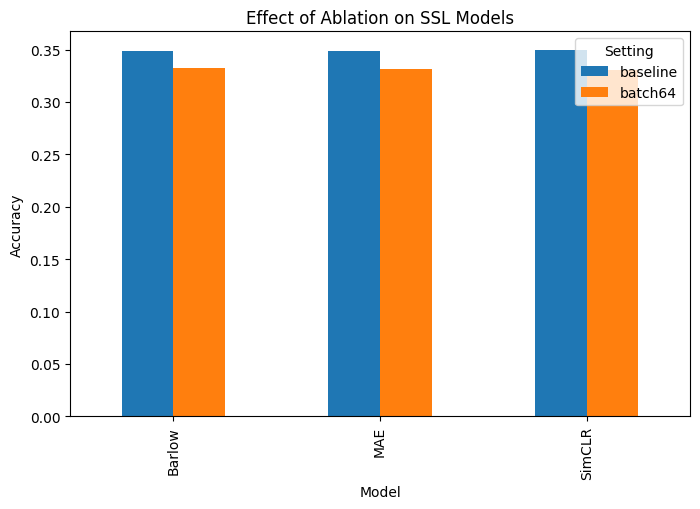

In [31]:
mean_acc = df.groupby(["Model","Setting"])["Accuracy"].mean().unstack()
mean_acc.plot(kind="bar", figsize=(8,5))
plt.ylabel("Accuracy")
plt.title("Effect of Ablation on SSL Models")
plt.show()
